# Numerical verification of ESCDD scaling

We compare different dynamical decoupling (DD) protocols for robustly implementing a negative evolution time under an arbitrary system Hamiltonian $H_0$.  

Here, we choose $H_0$ to be a randomly generated 2-qubit Hamiltonian in order to reproduce the results shown in the appendix.  
Specifically, we compare the following four DD protocols:

1. **Raw DD** — a basic 16-pulse ($4^2$) Pauli-group sequence that perfectly decouples $H_0$ in the ideal, zero-width pulse limit.  
2. **Eulerian DD** — a 64-pulse ($2\times2\times4^2$) first-order Eulerian-cycle construction that compensates for finite-width pulse effects.  
3. **Symmetric Eulerian DD** — a 128-pulse ($2\times64$) time-reversal-symmetric extension of the Eulerian sequence, suppressing higher-order error terms.  
4. **Concatenated Symmetric DD (ESCDD)** — a 16384-pulse ($128^2$) concatenated and symmetrized version with concatenation level $k=2$ for further robustness.


The Eulerian-cycle sequences are generated by applying Hierholzer’s algorithm to the Cayley graph of $\mathcal{G}_2$, using the generating set $\Gamma = \{X_1, X_2, Y_1, Y_2\}$.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random
from scipy.linalg import expm
from Eulerian import *


In [2]:
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
I = np.eye(2, dtype=complex)

In [3]:
cycle = find_eulerian_cycle(generate_cayley_graph(2))
Euler_cycle = compute_transition_paulis(cycle)
Euler_cycle_mat = [create_sum_matrix(pauli) for pauli in Euler_cycle]

pauli_elements = generate_pauli_group(2)
pulse_elements = compute_transition_paulis(pauli_elements)
pulse_elements.append(pauli_elements[-1])
Naive_cycle_mat_2 = [create_sum_matrix(pauli) for pauli in pulse_elements]

In [4]:

def random_pauli_combination_matrix(n_qubits, n_terms=None):
    """
    Generates matrix of random linear combination of n-qubit Pauli operators
    
    Args:
        n_qubits: Number of qubits
        n_terms: Number of terms to include (default: all 4^n terms)
    
    Returns:
        Tuple of (matrix, dictionary of terms with coefficients)
    """
    # Generate all possible Pauli strings
    all_paulis = [''.join(p) for p in product('IXYZ', repeat=n_qubits)]
    
    # Select terms and generate random coefficients
    if n_terms is None:
        n_terms = len(all_paulis)
    selected = np.random.choice(all_paulis, size=min(n_terms, len(all_paulis)), replace=False)
    coeffs = np.random.uniform(0, 1, size=len(selected))
    
    # Build the linear combination
    result = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)
    terms = {}
    
    for pauli, c in zip(selected, coeffs):
        terms[pauli] = c
        result += c * tensor_product(pauli)
    
    return result, terms


In [5]:
# H_0 is an arbitrary 2-qubit Hamiltonian
H0 = random_pauli_combination_matrix(2)[0]

In [6]:
# --- Finite-width pulses ---
def U(H, H0, tp):
    """Forward finite-width π/2 pulse under drift H0."""
    return scipy.linalg.expm(-1j * (np.pi / 2 * H + tp * H0))

def U_rev(H, H0, tp):
    """Reverse finite-width −π/2 pulse under drift H0."""
    return scipy.linalg.expm(-1j * (-np.pi / 2 * H + tp * H0))


def EDD(H0, tau, tp):
    """First-order EDD sequence."""
    DD = np.eye(4)
    for M in Euler_cycle_mat:
        DD = (U(M, H0, tp) @ ftau) @ DD
    return DD

def EDD_symm(H0, tau, tp):
    """Symmetrized first-order EDD sequence."""
    DD = np.eye(4)
    # Forward cycle
    for M in Euler_cycle_mat:
        DD = (U(M, H0, tp) @ ftau) @ DD
    # Reverse cycle
    for M in reversed(Euler_cycle_mat):
        DD = (ftau @ U_rev(M, H0, tp)) @ DD
    return DD

def gate_fidelity(U,V,site):
    return 1-abs(np.trace(U@V.conj().T))/2**site

In [7]:
#If needed (e.g., for very small t_p):

def project_to_unitary(A):
    """project to the closest unitary A (polar decomposition)."""
    U, _ = scipy.linalg.polar(A)
    return U

In [9]:

# Initialize storage
e_naive = []
e_DCG = []
e_DCG_symm = []
e_Naive = []
e_symm_CDD = []
e_symm_CDD_symm = []

# Parameters
tp = 1e-3
taulist = np.logspace(-3, -1, 20)

# Simulation loop
for tau in taulist:
    U_targ = np.kron(I, I)
    ftau = scipy.linalg.expm(-1j * H0 * tau)
    
    # EDD (unsymmetrized)
    DD2 = np.eye(4)
    for M in Euler_cycle_mat:
        DD2 = (U(M, H0, tp) @ ftau) @ DD2

    # EDD (symmetrized)
    DD3 = np.eye(4)
    for M in Euler_cycle_mat:
        DD3 = (U(M, H0, tp) @ ftau) @ DD3
    for M in reversed(Euler_cycle_mat):
        DD3 = (ftau @ U_rev(M, H0, tp)) @ DD3
        
    # Naive DD sequence
    DD_naive = np.eye(4)
    for M in Naive_cycle_mat_2:
        DD_naive = (U(M, H0, tp) @ ftau) @ DD_naive
    
    
    # Concatenated Symmetrized Eulearian DD (ESCDD1_symm)
    ESCDD1_symm = np.eye(4, dtype=complex)
    EDD_block = EDD_symm(H0, tau, tp)
    reunitarize_every = 300
    mults = 0  # multiplication counter
    
    # Forward pass
    for M in Euler_cycle_mat:
        ESCDD1_symm = (U(M, H0, tp) @ EDD_block) @ ESCDD1_symm
        mults += 2
        if mults % reunitarize_every == 0:
            ESCDD1_symm = project_to_unitary(ESCDD1_symm)

    # Reverse pass
    for M in reversed(Euler_cycle_mat):
        ESCDD1_symm = (EDD_block @ U_rev(M, H0, tp)) @ ESCDD1_symm
        mults += 2
        if mults % reunitarize_every == 0:
            ESCDD1_symm = project_to_unitary(ESCDD1_symm)

    ESCDD1_symm = ESCDD1_symm 
        
    # Gate infidelity evaluation
    e_Naive.append(gate_fidelity(DD_naive, U_targ, 2))
    e_DCG.append(gate_fidelity(DD2, U_targ, 2))
    e_DCG_symm.append(gate_fidelity(DD3, U_targ, 2))
    e_symm_CDD_symm.append(gate_fidelity(ESCDD1_symm, U_targ, 2))


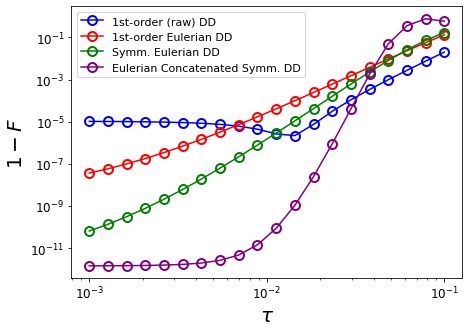

In [10]:
fig,ax = plt.subplots(figsize = (7,5))
ms=9
ax.plot(taulist,e_Naive, 'o-', color = 'blue', markersize = ms, \
        markeredgecolor='blue', markerfacecolor="None", markeredgewidth=2, label = '1st-order (raw) DD')
ax.plot(taulist,e_DCG, 'o-', color = 'red', markersize = ms, \
        markeredgecolor='red', markerfacecolor="None", markeredgewidth=2, label = '1st-order Eulerian DD')
ax.plot(taulist,e_DCG_symm, 'o-', color = 'green', markersize = ms, \
        markeredgecolor='green', markerfacecolor="None", markeredgewidth=2, label = 'Symm. Eulerian DD')
ax.plot(taulist,e_symm_CDD_symm, 'o-', color = 'purple', markersize = ms, \
        markeredgecolor='purple', markerfacecolor="None", markeredgewidth=2, label = 'Eulerian Concatenated Symm. DD')


ax.set_xlabel(r'$\tau$', fontsize = 20)
ax.set_ylabel(r'$1 - F$', fontsize = 20)
ax.legend(fontsize = 11)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

#fig.savefig("ESCDD", bbox_inches = 'tight', dpi = 200)